# Quark-Gluon (Quantum)

This notebooks trains and evaluates quantum vision transformers for the quark-gluon classification task.
You can find information about the dataset at  https://arxiv.org/abs/1902.08276.

In [1]:
import jax

from quantum_transformers.utils import plot_image
from quantum_transformers.datasets import get_quark_gluon_dataloaders
from quantum_transformers.training import train_and_evaluate
from quantum_transformers.transformers import VisionTransformer
from quantum_transformers.quantum_layer import get_circuit

data_dir = '/global/cfs/cdirs/m4392/salcc/data'

2024-04-10 20:05:16.162975: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 20:05:16.163000: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 20:05:16.163023: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-10 20:05:19.658088: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Please first ``pip install -U cirq`` to enable related functionality in translation module


The models are trained using the following devices:

In [2]:
for d in jax.devices():
    print(d, d.device_kind)

gpu:0 NVIDIA A100-SXM4-80GB


Let's check how many samples the dataset has, the shape of the input data, and how one sample looks like.

Cardinalities (train, val, test): 714510 79390 139306
(125, 125, 3)


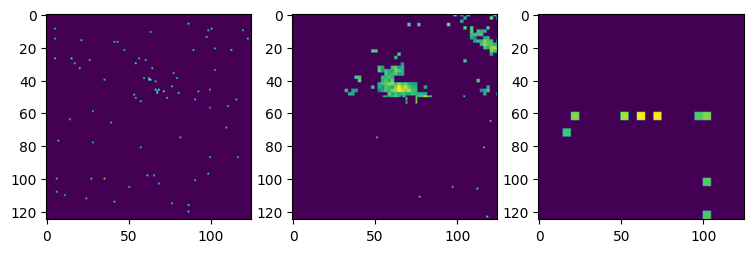

In [3]:
qg_train_dataloader, qg_val_dataloader, qg_test_dataloader = get_quark_gluon_dataloaders(batch_size=256, data_dir=data_dir)
first_image = next(iter(qg_train_dataloader))[0][0]
print(first_image.shape)
plot_image(first_image, abs_log=True)

Now let's train the quantum vision transformer on the best hyperparameters found using random hyperparameter search.

In [4]:
model = VisionTransformer(num_classes=2, patch_size=10, hidden_size=8, num_heads=2, num_transformer_blocks=4, mlp_hidden_size=4,
                          quantum_attn_circuit=get_circuit(), quantum_mlp_circuit=get_circuit())
metrics = train_and_evaluate(model, qg_train_dataloader, qg_val_dataloader, qg_test_dataloader, num_classes=2, num_epochs=30)

Number of parameters = 4170


Epoch  30/30: 100%|██████████| 2791/2791 [38:39<00:00,  1.20batch/s, Loss = 0.6034, AUC = 0.780, Train time = 1704.41s]


Best validation AUC = 0.780 at epoch 25
Total training time = 51187.73s, total time (including evaluations) = 69696.81s


Testing: 100%|██████████| 544/544 [01:48<00:00,  5.02batch/s, Loss = 0.6120, AUC = 0.775]


In [5]:
import pickle
with open('qg_metrics.pkl', 'wb') as f:
    pickle.dump(metrics, f)